# A cellular level simulation of chemotaxis behavior

Q1: At a cellular level, how does the cell respond to a gradient?

Q2: Why the cell tumbles about every second when no ligand is present?

The file includes:
 - Model specification
 - Visualizing the trajectories for 3 cells in response to gradients with different background tumbling frequencies
 - Comparing the behaviors of cells of different background tumbling frequencies

## Part1: Model specification

#### Assumptions
1. Run. The background average duration of each run (`time_exp`) is a variable of interst. When the cell senses concentration change, the cell changes the expected run duration (`exp_run_time`). The duration of each run follows an exponential distribution with mean = `exp_run_time`. 
2. Tumble. The duration of cell tumble follows an exponential distribution with mean 0.1s. When it tumbles, we assume it only changes the orientation for the next run but doesn't move in space. 
3. Response. As we've seen in the BNG model, the cell can respond to the gradient change within 0.5 seconds. In this model, we allow cells to re-measure the concentration after it runs for 0.5 seconds.
4. Gradient. We model an exponential gradient centered at [1200, 1200] with a concentration of 10^8.5. All cells start at [0, 0], which has a concentration of 10^2. The receptors saturate at a concentration of 10^8. 
5. Performance. The closer to the center of the gradient the better.

#### Dependencies
Please makes sure have dependencies installed:
 - [Numpy](https://numpy.org/install/)
 - [Matplotlib](https://matplotlib.org/users/installing.html)
 - [Colorspace](https://python-colorspace.readthedocs.io/en/latest/installation.html) (simply [install with pip](https://pypi.org/project/colorspace/) works too)

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import math
from matplotlib import colors
from matplotlib import patches
import colorspace

#### Specifying parameters

In [63]:
SEED = 128  #Any random seed
np.random.seed(SEED)

#Constants for E.coli tumbling
tumble_angle_mu, tumble_angle_std = 2 * math.pi * 68 / 360, 2 * math.pi * 36 / 360 #Degree of reorientation when tumble
tumble_time_mu = 0.1

#E.coli movement constants
speed = 20         #um/s, speed of E.coli movement
sec_per_step = 0.5 #Able to respond every 0.5 second
step_size, step_per_sec = speed * sec_per_step, 1.0 / sec_per_step

#Model constants
start = [0, 0]  #All cells start at [0, 0]
ligand_center = [1500, 1500] #Position of highest concentration
center_exponent, start_exponent = 8, 2
origin_to_center = 0 #Distance from start to center, intialized here, will be actually calculated later
saturation_conc = 10 ** 8 #From BNG model

#### Helper function: calculate Euclidean distance

In [64]:
# Calculates Euclidean distance between point a and b
def euclidean_distance(a, b):
    return math.sqrt((a[0] - b[0]) ** 2 + (a[1] - b[1]) ** 2)

#### Function to calculate concentration at a current location
We model an exponential gradient centered at [1500, 1500] with a concentration of 10^8. All cells start at [0, 0], which has a concentration of 10^2.

In [65]:
# Exponential gradient, the exponent follows a linear relationship with distance to center
def calc_concentration(pos):
    dist = euclidean_distance(pos, ligand_center)
    exponent = (1 - dist / origin_to_center) * (center_exponent - start_exponent) + start_exponent
    
    return 10 ** exponent

#### Function to calculate run duration
The run duration follows an exponential distribution with `exp_run_time`.

When no gradient is present, `exp_run_time` = `time_exp`. When there is a change in ligand concentration, `exp_run_time` changes accordingly. The change is calculated as `(curr_conc - past_conc) / past_conc` to normalize for the exponential gradient. We model this response with `exp_run_time` = `time_exp` + 10 * `change`.

In [66]:
# Calculate the wait time for next tumbling event
def run_time(curr_conc, past_conc, position, time_exp):
        
    curr_conc = min(curr_conc, saturation_conc) #Can't detect higher concentration if receptors saturates
    past_conc = min(past_conc, saturation_conc)
    change = (curr_conc - past_conc) / past_conc #proportion change in concentration
    exp_run_time = time_exp * (1 + 10 * change)
    
    #print(exp_run_time, curr_conc, past_conc, position)
    
    if exp_run_time < 0.000001:
        exp_run_time = 0.000001 #positive wait times
    elif exp_run_time > 4 * time_exp:
        exp_run_time = 4 * time_exp     #the decrease to tumbling frequency is only to a certain extent
    curr_run_time = np.random.exponential(exp_run_time)
    
    return curr_run_time

#### Function to calculate tumble duration and reorientation

The duration of cell tumble follows an exponential distribution with mean 0.1s. When it tumbles, we assume it only changes the orientation for the next run but doesn't move in space. 

The degree of reorientation follows a uniform distribution with mean 68 and std 36.

Also return the horizontal and vertical movement of the cell for the following run.

In [67]:
# Horizontal and Vertical movement of tumbling
def tumble_move(curr_dir):
    #Sample the new direction
    new_dir = np.random.normal(loc = tumble_angle_mu, scale = tumble_angle_std)
    new_dir *= np.random.choice([-1, 1])
    new_dir += curr_dir
    
    if new_dir > 2 * math.pi:
        new_dir -= 2 * math.pi #Keep within [0, 2pi]
        
    move_h = math.cos(new_dir) #Horizontal displacement for next run
    move_v = math.sin(new_dir) #Vertical displacement for next run
    
    tumble_time = np.random.exponential(tumble_time_mu) #Length of the tumbling
    
    return new_dir, move_h, move_v, tumble_time

#### Function for simulation

It handles simulation through time for all `time_exp` of all cells.

For each cell, simulate through time as the following:

while `t` < duration:
- Assess the current concentration
- Update current run duration `curr_run_time` and whether it is up/down gradient
- If `curr_run_time` < 0.5s:
    - run for `curr_run_time` second along current direction
    - Sample the duration of tumble `tumble_time` and the resulted direction
    - increment t by `curr_run_time` and `tumble_time`
- If `curr_run_time` > 0.5s:
    - run for 0.5s along current direction
    - increment `t` by 0.5s (and then the cell will re-assess the new concentration, and decide the duration of next run)

In [83]:
def simulate(num_cells, duration, time_exp):

    path = np.zeros((len(time_exp), num_cells, duration + 1, 2))
    terminals = [[] for i in range(len(time_exp))]

    for freq_i in range(len(time_exp)):
        for rep in range(num_cells):
            # Initialize simulation
            t = 0
            curr_position = np.array(start)
            past_conc = calc_concentration(start) #Initialize concentration
            curr_direction, move_h, move_v, tumble_time = tumble_move(0) #Initialize direction randomly

            while t < duration:
                curr_conc = calc_concentration(curr_position)

                curr_run_time = run_time(curr_conc, past_conc, curr_position, time_exp[freq_i]) #get wait time

                # if run time (r) is within the step (s), run for r second and then tumble
                if curr_run_time < sec_per_step: 
                    curr_position = curr_position + np.array([move_h, move_v]) * speed * curr_run_time
                    curr_direction, move_h, move_v, tumble_time = tumble_move(curr_direction)
                    t += (curr_run_time + tumble_time)
                
                # if r > s, run for r; then it will be in the next iteration
                else:
                    curr_position = curr_position + np.array([move_h, move_v]) * speed * sec_per_step
                    t += sec_per_step

                #record position approximate for integer number of second
                curr_sec = int(t)
                if curr_sec <= duration:
                    path[freq_i, rep, curr_sec] = curr_position.copy()
                    past_conc = curr_conc
            
            terminals[freq_i].append((path[freq_i, rep, -1]))
    
    return terminals, path

## Part2: Visualizing trajectories

Run simulations for `time_exp = [0.1, 0.25, 0.5, 1.0, 2.0, 5.0, 10.0]`, 3 cells each, for 500 seconds.

In [84]:
#Run simulation for 3 cells with different background tumbling frequencies, Plot path

duration = 800   #seconds, duration of the simulation
num_cells = 3
origin_to_center = euclidean_distance(start, ligand_center) #Update the global constant
time_exp = [0.1, 0.25, 0.5, 1.0, 2.0, 5.0, 10.0]


terminals, path = simulate(num_cells, duration, time_exp)

#### Plotting the trajectories.

It will take some time to run.

- The background color white->red indicates ligand concentration
- Black dot indicates starting position of all cells ([0, 0]).
- Red dot indicates terminal position of all cells.
- The dashed line with colors dark->ligt green/cyan/purple indicates trajectories of the three cells. Darker dots indicate earlier time points.
- If the center has a higher concentration than 10^8 (saturation), the dark dashed circle indicates inside which concentration>10^8.

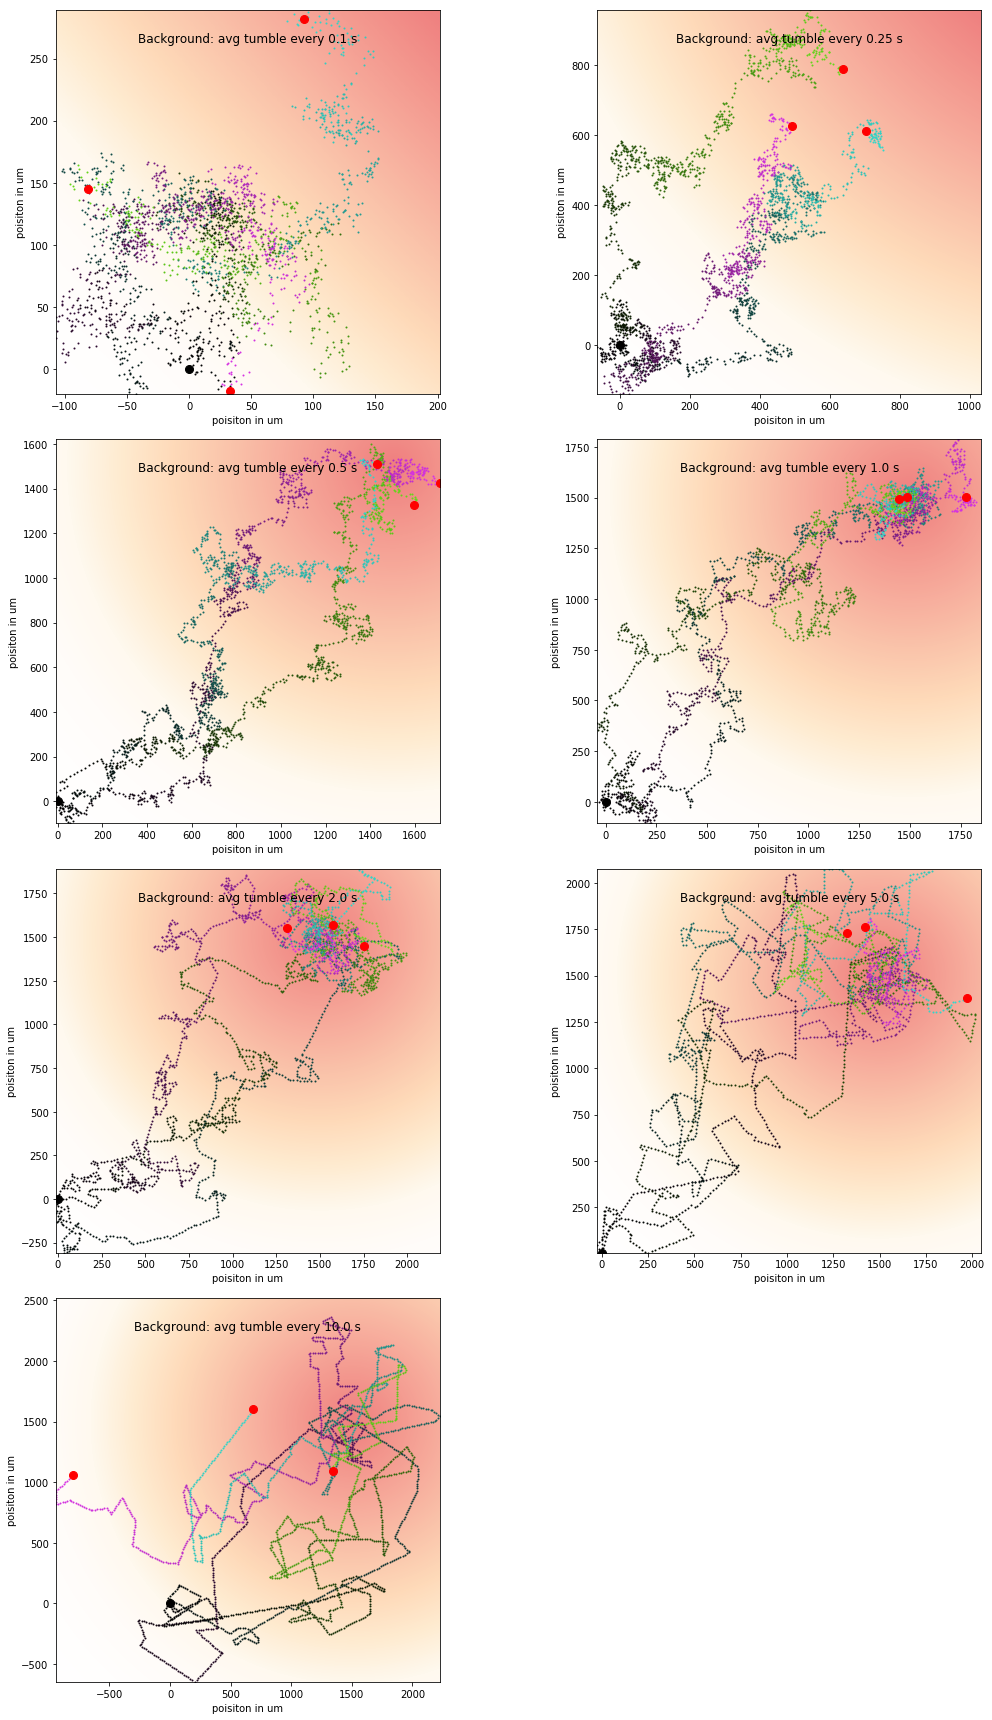

In [70]:
#Below are all for plotting purposes
radius_saturation = (1 - ((math.log10(saturation_conc) - start_exponent) / (center_exponent - start_exponent))) * origin_to_center

num_fig_row = round(len(time_exp) / 2.0)
fig, ax = plt.subplots(num_fig_row, 2, figsize = (16, 24))

#First set color map
mycolor = [[256, 256, 256], [256, 255, 254], [256, 253, 250], [256, 250, 240], [255, 236, 209], [255, 218, 185], [251, 196, 171], [248, 173, 157], [244, 151, 142], [240, 128, 128]] #from coolors：）
for i in mycolor:
    for j in range(len(i)):
        i[j] *= (1/256)
cmap_color = colors.LinearSegmentedColormap.from_list('my_list', mycolor)

for freq_i in range(len(time_exp)):
    index1, index2 = freq_i // 2, freq_i % 2
    xlen = max(path[freq_i,:,:,0].flatten()) - min(path[freq_i,:,:,0].flatten())
    ylen = max(path[freq_i,:,:,1].flatten()) - min(path[freq_i,:,:,1].flatten())
    sqrlen = int(round(max(xlen, ylen), 0))
    xlim_l, xlim_h = min(path[freq_i,:,:,0].flatten()), min(path[freq_i,:,:,0].flatten()) + sqrlen
    ylim_l, ylim_h = min(path[freq_i,:,:,1].flatten()), min(path[freq_i,:,:,1].flatten()) + sqrlen


    #Simulate the gradient distribution, plot as a heatmap
    conc_matrix = np.zeros((sqrlen, sqrlen))
    for i in range(sqrlen):
        for j in range(sqrlen):
            conc_matrix[i][j] = calc_concentration([i + xlim_l, j + ylim_l])
    conc_matrix = np.log(conc_matrix)
    ax[index1][index2].imshow(conc_matrix.T, cmap=cmap_color, interpolation='nearest', extent = [xlim_l, xlim_h, ylim_l, ylim_h], origin = 'lower')

    #Plot simulation results
    time_frac = 1.0 / duration
    #Time progress: dark -> colorful
    for t in range(duration):
        ax[index1][index2].plot(path[freq_i,0,t,0], path[freq_i,0,t,1], 'o', markersize = 1, color = (0.2 * time_frac * t, 0.85 * time_frac * t, 0.8 * time_frac * t))
        ax[index1][index2].plot(path[freq_i,1,t,0], path[freq_i,1,t,1], 'o', markersize = 1, color = (0.85 * time_frac * t, 0.2 * time_frac * t, 0.9 * time_frac * t))
        ax[index1][index2].plot(path[freq_i,2,t,0], path[freq_i,2,t,1], 'o', markersize = 1, color = (0.4 * time_frac * t, 0.85 * time_frac * t, 0.1 * time_frac * t))
    ax[index1][index2].plot(start[0], start[1], 'ko', markersize = 8)
    for i in range(num_cells):
        ax[index1][index2].plot(terminals[freq_i][i][0], terminals[freq_i][i][1], 'ro', markersize = 8)
    #ax.plot(path[:,0], path[:,1], '-', color = 'grey')

    #Indicate the saturation areas
    circle1 = plt.Circle((ligand_center[0], ligand_center[0]), radius_saturation, fill = False, ec = "black", ls = '--')
    ax[index1][index2].set_title("Background: avg tumble every {} s".format(time_exp[freq_i]), x = 0.5, y = 0.9)
    ax[index1][index2].add_artist(circle1)
    ax[index1][index2].set_xlim(xlim_l, xlim_h)
    ax[index1][index2].set_ylim(ylim_l, ylim_h)
    ax[index1][index2].set_xlabel("poisiton in um")
    ax[index1][index2].set_ylabel("poisiton in um")

if len(time_exp) % 2 != 0:
    fig.delaxes(ax[num_fig_row - 1, 1]) #delete the last figure if odd number of subplots
fig.tight_layout()

plt.show()

## Part3: Comparing performances

Run simulations for `time_exp = [0.1, 0.25, 0.5, 1.0, 2.0, 5.0, 10.0]`, 500 cells each, for 1000 seconds. Mean and std for Euclidean distance to the center are calculated for each `time_exp` at each time point.

It will take some time to run.

In [75]:
#Run simulation for 500 cells with different background tumbling frequencies, Plot average distance to highest concentration point
duration = 1500   #seconds, duration of the simulation
num_cells = 500
time_exp = [0.1, 0.25, 0.5, 1.0, 2.0, 5.0, 10.0]
origin_to_center = euclidean_distance(start, ligand_center) #Update the global constant
radius_saturation = (1 - ((math.log10(saturation_conc) - start_exponent) / (center_exponent - start_exponent))) * origin_to_center

all_distance = np.zeros((len(time_exp), num_cells, duration)) #Initialize to store results

terminals, paths = simulate(num_cells, duration, time_exp) #run simulation

for freq_i in range(len(time_exp)):
    for c in range(num_cells):
        for t in range(duration):
            pos = paths[freq_i, c, t]
            dist = euclidean_distance(ligand_center, pos)
            all_distance[freq_i, c, t] = dist

all_dist_avg = np.mean(all_distance, axis = 1)
all_dist_std = np.std(all_distance, axis = 1)

#### Plotting distances.

- Each colored line indicates a `time_exp`, plotting average distances for the 500 cells
- The shaded area is standard deviation
- Grey dashed line indicates distance below where concentration reaches 10^8.

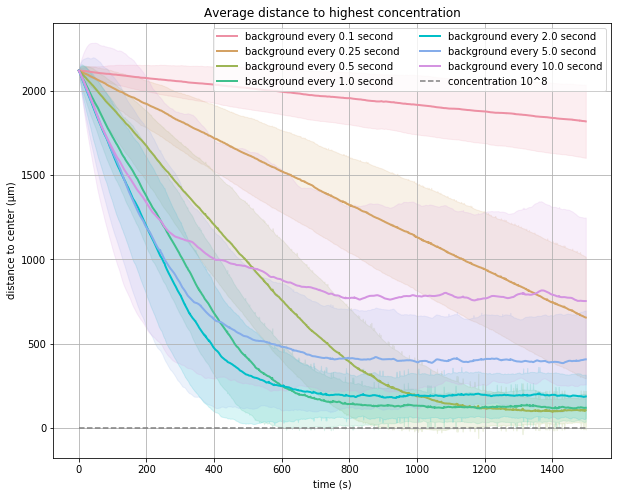

In [76]:
#Below are all for plotting purposes
#Define the colors to use
colors = colorspace.qualitative_hcl(h=[0, 300.], c = 60, l = 70, pallete = "dynamic")(len(time_exp))

xs = np.arange(0, duration)

fig, ax = plt.subplots(1, figsize = (10, 8))

for freq_i in range(len(time_exp)):
    mu, sig = all_dist_avg[freq_i], all_dist_std[freq_i]
    ax.plot(xs, mu, lw=2, label="background every {} second".format(time_exp[freq_i]), color=colors[freq_i])
    ax.fill_between(xs, mu + sig, mu - sig, color = colors[freq_i], alpha=0.15)

ax.set_title("Average distance to highest concentration")
ax.set_xlabel('time (s)')
ax.set_ylabel('distance to center (µm)')
ax.hlines(radius_saturation, 0, duration, colors='gray', linestyles='dashed', label='concentration 10^8')
ax.legend(loc='upper right', ncol = 2)

ax.grid()